## Aitchison Distribution on the Simplex

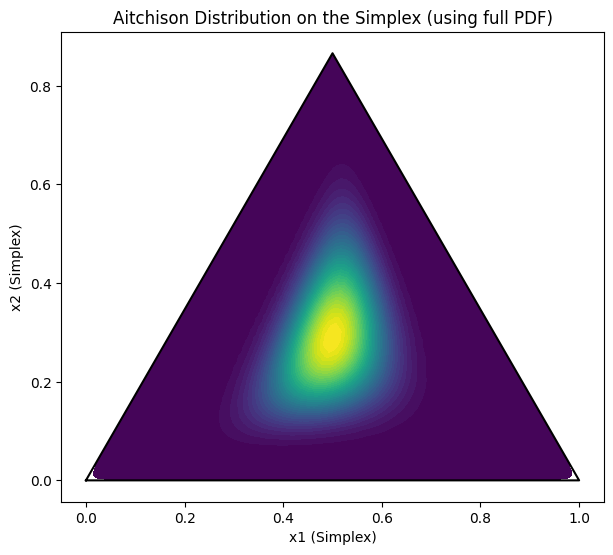

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import multivariate_normal


# Define the centered log-ratio (CLR) transformation and its inverse
def clr_inverse(z):
    """Inverse of the centered log-ratio transformation."""
    exp_z = np.exp(z)
    return exp_z / np.sum(exp_z, axis=-1, keepdims=True)


# Define the geometric mean function used in the log transformation
def geometric_mean(x):
    """Calculate the geometric mean of a composition."""
    return np.exp(np.mean(np.log(x), axis=-1, keepdims=True))


# Full Aitchison PDF calculation
def aitchison_pdf(x, mu, sigma_inv, det_sigma, D):
    """Calculate the Aitchison PDF based on the provided formula."""
    clr_x = np.log(x / geometric_mean(x))  # Centered log-ratio transformation
    diff = clr_x - mu
    exponent = -0.5 * np.sum(diff @ sigma_inv * diff, axis=-1)

    # PDF of the Aitchison distribution
    normal_part = np.exp(exponent) / np.sqrt((2 * np.pi) ** (D - 1) * det_sigma)
    jacobian_part = 1.0 / np.prod(x, axis=-1)

    return normal_part * jacobian_part


# Define a function to transform points from the 3D composition back to 2D (barycentric coordinates)
def simplex_projection(comp):
    """Project 3D compositions (x1, x2, x3) onto a 2D simplex (triangle)."""
    x1 = comp[..., 0]
    x2 = comp[..., 1]
    x3 = comp[..., 2]
    return np.stack([0.5 * (2 * x2 + x3), np.sqrt(3) / 2 * x3], axis=-1)


# Parameters for the Aitchison distribution (using a multivariate normal in CLR space)
mu = np.array([0, 0, 0])  # Mean in CLR space
cov = np.array([[0.1, 0.3, 0], [0, 0.3, 0.1], [0, 0, 0.1]])  # Covariance matrix

# Calculate the inverse of the covariance matrix and its determinant
sigma_inv = np.linalg.inv(cov)
det_sigma = np.linalg.det(cov)

# Create grid of points in the CLR space for x1 and x2
x1 = np.linspace(-3, 3, 100)
x2 = np.linspace(-3, 3, 100)
X1, X2 = np.meshgrid(x1, x2)

# Compute the log ratios (z1, z2) and set the third one to be dependent (so that z1 + z2 + z3 = 0)
Z = np.stack([X1, X2, -X1 - X2], axis=-1)

# Apply the inverse CLR transformation to get back to the simplex
compositions = clr_inverse(Z)

# Calculate the Aitchison PDF for the compositions
pdf_aitchison = aitchison_pdf(compositions, mu, sigma_inv, det_sigma, D=3)

# Project the 3D compositions onto the 2D simplex (to get a triangle plot)
simplex_coords = simplex_projection(compositions)

# Plot the density in the 2D simplex (triangle)
plt.figure(figsize=(7, 7))
plt.tricontourf(simplex_coords[:, :, 0].flatten(), simplex_coords[:, :, 1].flatten(), pdf_aitchison.flatten(),
                levels=50, cmap='viridis')
# plt.colorbar(label='Density')

# Plot the borders of the 2D simplex (triangle)
triangle = np.array([[0, 0], [1, 0], [0.5, np.sqrt(3) / 2], [0, 0]])  # Vertices of an equilateral triangle
plt.plot(triangle[:, 0], triangle[:, 1], color='black')

plt.title('Aitchison Distribution on the Simplex (using full PDF)')
plt.xlabel('x1 (Simplex)')
plt.ylabel('x2 (Simplex)')
plt.gca().set_aspect('equal', adjustable='box')
plt.show()

## Logistic Normal Distribution on the Simplex

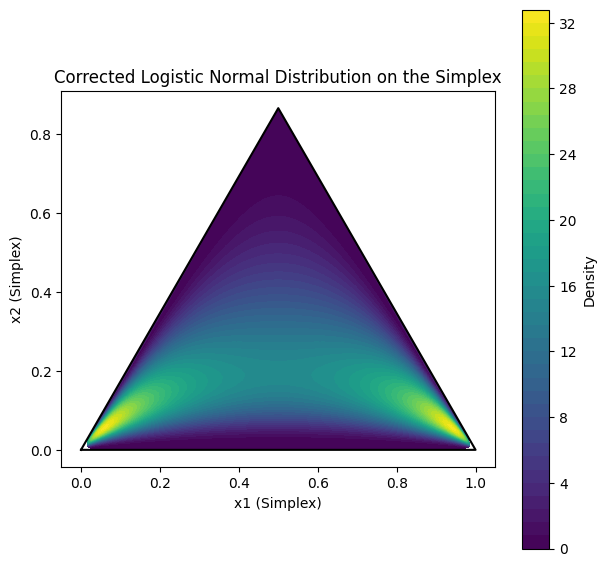

In [7]:
mu = np.array([0, 0, 0])  # Mean in CLR space
cov = np.array([[1, 0, 0], [0, 1, 0], [0, 0, 1]])  # Covariance matrix

# Calculate the inverse of the covariance matrix and its determinant
sigma_inv = np.linalg.inv(cov)
det_sigma = np.linalg.det(cov)

mu_adjusted = mu[:-1]  # Only take the first (D-1) components

# Corrected Logistic Normal PDF calculation based on the exact formula, with shape fixes
def logistic_normal_pdf_corrected(x, mu, sigma_inv, det_sigma, D):
    """Calculate the Logistic Normal PDF using the correct formula, with shape fixes."""
    # Last component s_N = 1 - sum of the first (D-1) components
    s_N = 1 - np.sum(x[:, :, :-1], axis=-1, keepdims=True)
    
    # Ensure no components are zero to avoid log(0)
    epsilon = 1e-12
    s_N = np.clip(s_N, epsilon, 1 - epsilon)
    x = np.clip(x, epsilon, 1 - epsilon)
    
    # Log-ratio transformation (log(s_i / s_N) for i=1,...,N-1)
    log_ratios = np.log(x[:, :, :-1] / s_N)
    
    # Multivariate normal part in log-ratio space
    diff = log_ratios - mu_adjusted  # Adjust mu to have (D-1) components
    exponent = -0.5 * np.sum(diff @ sigma_inv[:2, :2] * diff, axis=-1)  # Only use top-left (D-1)x(D-1) block of sigma_inv
    
    # PDF of the Logistic Normal distribution
    normal_part = np.exp(exponent) / np.sqrt((2 * np.pi) ** (D - 1) * det_sigma)
    
    # Jacobian correction term (product of all s_i components)
    jacobian_part = 1.0 / (np.prod(x, axis=-1) * s_N[:, :, 0])
    
    return normal_part * jacobian_part

# Recompute the Logistic Normal PDF with the correct formula and shape fixes
pdf_logistic_normal_corrected = logistic_normal_pdf_corrected(compositions, mu, sigma_inv, det_sigma, D=3)

# Plot the corrected density in the 2D simplex (triangle)
plt.figure(figsize=(7, 7))
plt.tricontourf(simplex_coords[:, :, 0].flatten(), simplex_coords[:, :, 1].flatten(), pdf_logistic_normal_corrected.flatten(), levels=50, cmap='viridis')
plt.colorbar(label='Density')

# Plot the borders of the 2D simplex (triangle)
triangle = np.array([[0, 0], [1, 0], [0.5, np.sqrt(3)/2], [0, 0]])  # Vertices of an equilateral triangle
plt.plot(triangle[:, 0], triangle[:, 1], color='black')

plt.title('Corrected Logistic Normal Distribution on the Simplex')
plt.xlabel('x1 (Simplex)')
plt.ylabel('x2 (Simplex)')
plt.gca().set_aspect('equal', adjustable='box')
plt.show()